### Tabular playground series - September 2021

https://www.kaggle.com/competitions/tabular-playground-series-sep-2021/overview

For this competition, you will predict whether a customer made a claim upon an insurance policy. The ground truth claim is binary valued, but a prediction may be any number from 0.0 to 1.0, representing the probability of a claim. The features in this dataset have been anonymized and may contain missing values.

### Setup

In [1]:
%%capture

from catboost import CatBoostClassifier, Pool, cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(rc = {'figure.figsize':(10, 6)})
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

from ml_utils.preprocess.missing import check_missingness
from ml_utils.preprocess.pipeline import preprocessing_pipeline

### Load data

In [2]:
pipeline = {}

train = pd.read_csv("Data/train.csv")
train.drop('id', axis=1, inplace=True)
test = pd.read_csv("Data/test.csv")

print(f"Train shape {train.shape}")
print(f"Test shape {test.shape}")

Train shape (957919, 119)
Test shape (493474, 119)


In [3]:
train.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,1
4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,144.120,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,1



### Basic EDA


The training dataset is quite large with almost 1 million rows. Take a random sample of 10% of the data for analysis, before training on all of the data.

In [4]:
train_sample = train.sample(100000)

In [5]:
def get_col_summary(df: pd.DataFrame) -> pd.DataFrame:

    # Min max scale so variances are comparable
    df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)

    summary_fns = {
        "variance": np.var,
        "mean": np.mean,
        "median": np.median
    }

    _ = []
    for name, fn in summary_fns.items():
        _.append(df.apply(fn).to_frame(name=name))

    summary_df = pd.concat(_, axis=1)

    # Ignore var3 as this has already been analysed/dealt with 
    summary_df = summary_df[~summary_df.index.isin(["var3"])]

    return summary_df

col_summary = get_col_summary(train_sample)

<AxesSubplot:xlabel='variance', ylabel='Count'>

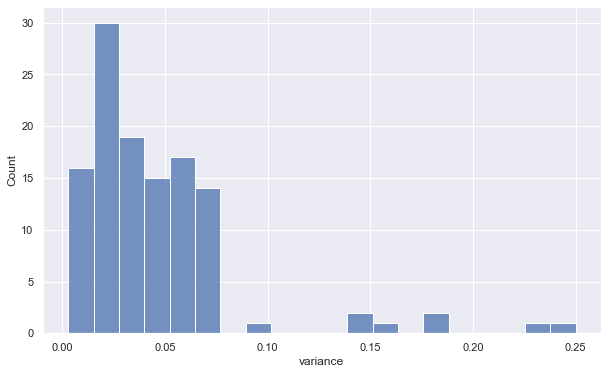

In [6]:
# Distribution of column variances
sns.histplot(col_summary["variance"], bins=20)

<AxesSubplot:xlabel='mean', ylabel='Count'>

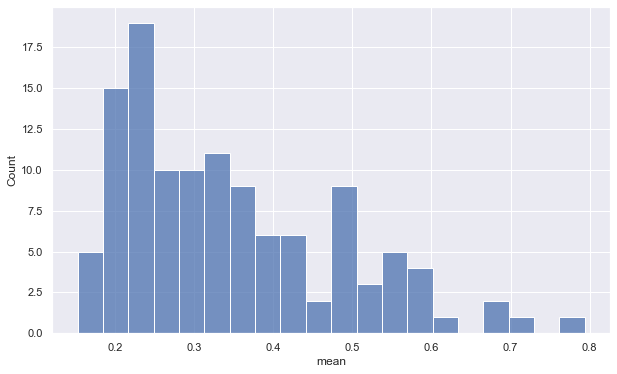

In [7]:
# Distribution of column means
sns.histplot(col_summary["mean"], bins=20)

Looks like the data has already been normalised, continue to use all features for now.

**Class imbalance**

In [8]:
train_sample['claim'].value_counts() / len(train_sample)

1    0.50099
0    0.49901
Name: claim, dtype: float64

### Missingness analysis

<AxesSubplot:ylabel='Count'>

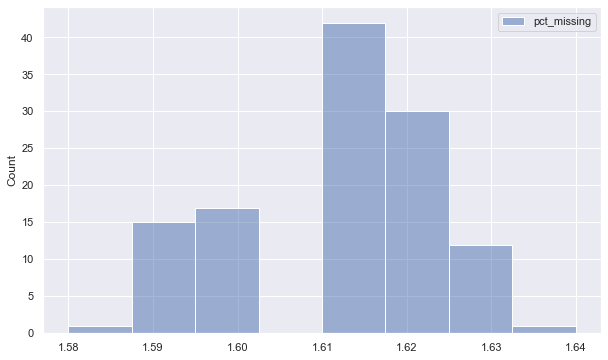

In [9]:
train_missingness = check_missingness(train)
sns.histplot(train_missingness)

118 of the columns have some missing data. All of these have low levels of missingness (c1.5%).

Analyse missing data for:
1. **Individual features**: does missing data at the feature level affect % claim?
2. **Row level** does the number of missing data points in each row help predict the target?

**Feature level missingness**

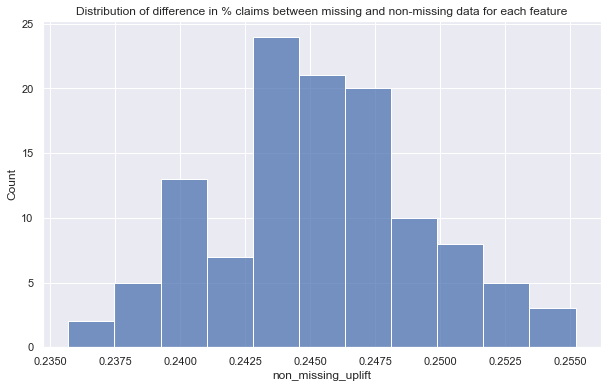

In [10]:
def plot_feature_missing_data_impact():
    """
    For each feature, calculate and plot the increase in claim %
    when data is non-missing compared to missing
    """

    missing_impact = {}

    temp_train = (
        train
            .copy()
            .isna()
            .drop('claim', axis=1)
    )
    temp_train = pd.concat([temp_train, train["claim"]], axis=1)

    feature_cols = list(train.drop('claim', axis=1).columns)

    for feature_col in feature_cols:
        missing = temp_train[temp_train[feature_col]]
        non_missing = temp_train[~temp_train[feature_col]]

        missing_impact[feature_col] = {
            "missing": missing['claim'].sum() / len(missing),
            "non-missing": non_missing['claim'].sum() / len(non_missing)
        }

    df_missing = pd.DataFrame(missing_impact).T
    df_missing['non_missing_uplift'] = df_missing['missing'] - df_missing['non-missing']

    ax = sns.histplot(df_missing['non_missing_uplift'])
    ax.set_title('Distribution of difference in % claims between missing and non-missing data for each feature')
    plt.show()

plot_feature_missing_data_impact()

**Conclusion of feature level missingness analysis**

For each feature, the missing data has a significant impact on the target variable.

To capture this in the model, add additional features signifying whether or not that feature was imputed (originally missing).

In [11]:
%%capture

def add_imputed_features(df):
    df = df.copy()

    try:
        feature_cols = list(df.drop('claim', axis=1).columns)
    except:
        feature_cols = list(df.columns)

    for feature_col in feature_cols:
        df[f"{feature_col}_imputed"] = np.where(df[feature_col].isna(), 1, 0)

    return df

train = add_imputed_features(train)

pipeline["add_imputed_features"] = (add_imputed_features, None)


**Row level missingness**

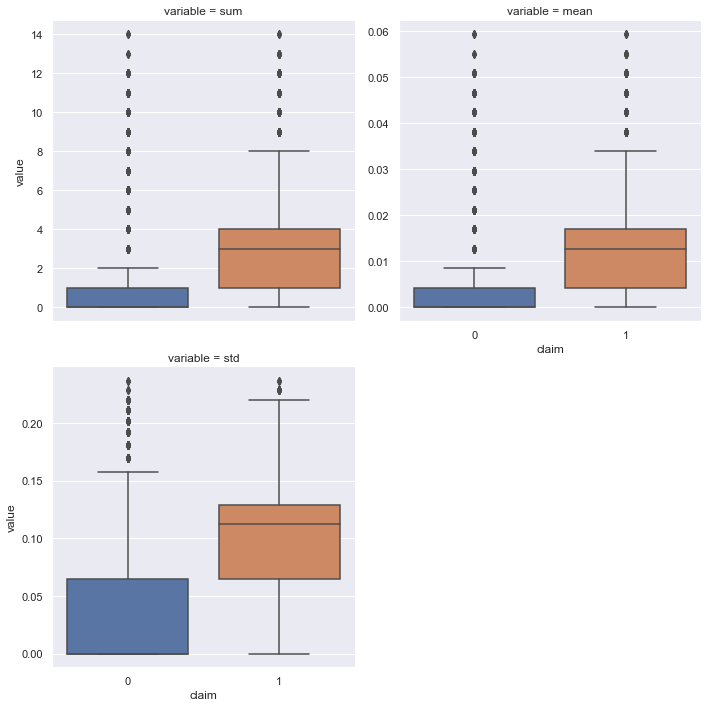

In [12]:
def get_row_level_missingness(df):
    """
    Get high level row missingness statistics and look at impact
    on target
    """
    df_no_target = df.copy().drop('claim', axis=1)

    try:
        df_no_target = df.copy().drop('claim', axis=1)
    except:
        df_no_target = df.copy()

    any_missing = df_no_target.isna().any(axis=1)
    any_missing = any_missing.to_frame(name="any")

    sum_missing = df_no_target.isna().sum(axis=1)
    sum_missing = sum_missing.to_frame(name="sum")

    mean_missing = df_no_target.isna().mean(axis=1)
    mean_missing = mean_missing.to_frame(name="mean")

    std_missing = df_no_target.isna().std(axis=1)
    std_missing = std_missing.to_frame(name="std")

    row_missing = pd.concat([
        any_missing,
        sum_missing,
        mean_missing,
        std_missing,
        train['claim']
    ], axis=1)

    return row_missing

row_missingness = get_row_level_missingness(train)

sns.catplot(
    data=row_missingness.drop('any', axis=1).melt(id_vars='claim'),
    x='claim', y='value',
    col='variable', kind='box', col_wrap=2,
    sharey=False
)

**Conclusion of row level missingness analysis**

Sum, mean and standard deviation of missing data within row have a noticable impact on target. Add features for these

In [13]:
# Impute the rest of the missing with mean
def impute_missing(df: pd.DataFrame) -> pd.DataFrame:
    col_names = df.columns
    df = pd.DataFrame(
        SimpleImputer(strategy="mean").fit_transform(df),
        columns=col_names
    )
    return df

pipeline["impute"] = (impute_missing, None)

train = impute_missing(train)

### Outliers

A lot of features aren't gaussian so can't reliably use z-scores for outliers.

~~Instead use interquartile range.~~

Some of the distributions are veryextremely skewed and a lot of the data are getting flagged as outliers.

**Come back to this later, potentially look at whether removing the outliers improves that features predictability?**

In [14]:
# x = train_sample['f112']
# tol = 1.5

# uq = np.percentile(x, 75)
# lq = np.percentile(x, 25)
# iqr = uq - lq

# lower_lim = lq - (iqr * tol)
# upper_lim = uq + (iqr * tol)

### Preprocess data

In [21]:
test = preprocessing_pipeline(test, pipeline)

### Model

The data set is very large. To avoid long train times with comparing a bunch of algorithms I'll be exclusively using catboost.

Main reasons:
 - Avoiding excessive training times using slow sklearn models which gradient boosting will likely outperform
 - Performance increases are likely to be far greater by tuning a single algorithm and improving the quality of features

In [17]:
X = train.drop("claim", axis=1)
y = train["claim"]

cat_params = {
    "iterations": 10e3,
    "learning_rate": 0.02,
    "depth": 8,
    "min_data_in_leaf": 11,
    'od_wait': 1100
}

cb = CatBoostClassifier(
    task_type="GPU",
    loss_function="Logloss",
    eval_metric="AUC",
    **cat_params
)

In [18]:
N_CV = 5

kfold = StratifiedKFold(n_splits=N_CV)

train_score = []
valid_score = []
test_set_preds = []

for fold, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
    print(f"Running fold: {fold}...")
    X_train, y_train = X.iloc[train_idx], y[train_idx]
    X_valid, y_valid = X.iloc[valid_idx], y[valid_idx]
    
    cb.fit(X_train, y_train)
    
    y_hat_train = cb.predict_proba(X_train)[:, 1]
    y_hat_test = cb.predict_proba(X_valid)[:, 1]
    
    train_score.append(roc_auc_score(y_train, y_hat_train))
    valid_score.append(roc_auc_score(y_valid, y_hat_test))
    
    # Fold prediction on test set
    y_hat = cb.predict_proba(test)[:,1]
    test_set_preds.append(y_hat)

Running fold: 0...
Running fold: 1...
Running fold: 2...
Running fold: 3...
Running fold: 4...


Mean train score 0.874342646386235
Mean test score 0.8042474551458936


<AxesSubplot:xlabel='fold', ylabel='accuracy'>

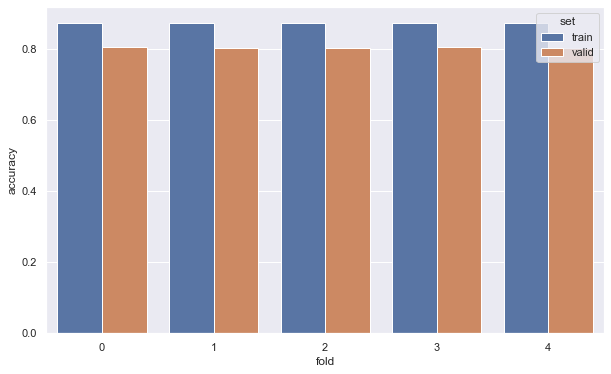

In [19]:
results_df = pd.DataFrame({
    "fold": list(range(N_CV)),
    "train": train_score,
    "valid": valid_score
})
results_df = pd.melt(results_df, id_vars="fold", var_name="set",value_name="accuracy")
print(f"Mean train score {np.mean(train_score)}")
print(f"Mean test score {np.mean(valid_score)}")
sns.barplot(data=results_df, x="fold", y="accuracy", hue="set")

### Final predictions and submission

In [20]:
submission = test[['id']].copy()
submission['id'] = submission['id'].astype(int)
submission["claim"] = np.mean(test_set_preds, axis=0)
submission.to_csv('Data/test_preds.csv', index=False)